# Lotka-Volterra system with some exponential Runge-Kutta method

In this example we present how to write a program to solve the Lotka-Volterra equations with Ponio.

The system is definied as:

$$
  \begin{aligned}
    \frac{\mathrm{d}x}{\mathrm{d}t} &= \alpha x  - \beta xy \\
    \frac{\mathrm{d}y}{\mathrm{d}t} &= \delta xy - \gamma y \\
  \end{aligned}
$$

where:

* $x$ is the number of prey
* $y$ is the number of predators
* $t$ represents time
* $\alpha$, $\beta$, $\gamma$ and $\delta$ are postive real parameters describing the interaction of the two species.

We would like to compute the invariant $V$ definied by:

$$
  V = \delta x - \gamma \ln(x) + \beta y - \alpha \ln(y)
$$

We will use the same decomposition into linear and non-linear as the Lawson presentation:
    
$$
    \dot{u} = Lu + N(t,u)
$$
with $u=(x,y)$ and:
$$
    L = \begin{pmatrix}\alpha & 0 \\ 0 & -\gamma\end{pmatrix}
    \qquad
    N:(t,u)\mapsto \begin{pmatrix}-\beta u_1u_2 \\ \delta u_1u_2 \end{pmatrix}
$$
Since the linear part is diagonal, we can use a `std::valarray` to reprensent it.

In [1]:
%system mkdir -p lv_demo

[]

In [2]:
%%writefile lv_demo/lv_exprk.cpp

#include <iostream>
#include <valarray>

#include "solver/solver.hpp"
#include "solver/observer.hpp"
#include "solver/problem.hpp"
#include "solver/butcher_methods.hpp"

int main()
{
    using state_t = std::valarray<double>;
    using namespace observer;

    double alpha = 2./3., beta=4./3., gamma=1., delta=1.;
    
    state_t L = { alpha, -gamma };
    auto N = [=]( double t, state_t const& u ) -> state_t {
        double x=u[0], y=u[1];
        return { -beta*x*y, delta*x*y };
    };
    auto pb  = ode::make_lawson_problem(L,N);

    double dt = 0.1;
    double tf = 100;
    state_t u_ini = {1.8,1.8};
    
    ode::solve(pb, ode::butcher::exprk22_t<double, state_t>()            , u_ini, {0.,tf}, dt, "lv_demo/lv_exprk_exprk22.dat"_fobs);
    ode::solve(pb, ode::butcher::krogstad_t<double, state_t>()           , u_ini, {0.,tf}, dt, "lv_demo/lv_exprk_k.dat"_fobs);
    ode::solve(pb, ode::butcher::cox_matthews_t<double, state_t>()       , u_ini, {0.,tf}, dt, "lv_demo/lv_exprk_cm.dat"_fobs);
    ode::solve(pb, ode::butcher::strehmel_weiner_t<double, state_t>()    , u_ini, {0.,tf}, dt, "lv_demo/lv_exprk_sw.dat"_fobs);
    ode::solve(pb, ode::butcher::hochbruck_ostermann_t<double, state_t>(), u_ini, {0.,tf}, dt, "lv_demo/lv_exprk_ho.dat"_fobs);
    ode::solve(pb, ode::butcher::etd2cf3_t<double, state_t>()            , u_ini, {0.,tf}, dt, "lv_demo/lv_exprk_etd2cf3.dat"_fobs);
    ode::solve(pb, ode::butcher::etd3rk_t<double, state_t>()             , u_ini, {0.,tf}, dt, "lv_demo/lv_exprk_etd3rk.dat"_fobs);

    return 0;
}

Writing lv_demo/lv_exprk.cpp


In [3]:
%system $CXX -std=c++20 -I ../include lv_demo/lv_exprk.cpp -o lv_demo/lv_exprk && ./lv_demo/lv_exprk

[]

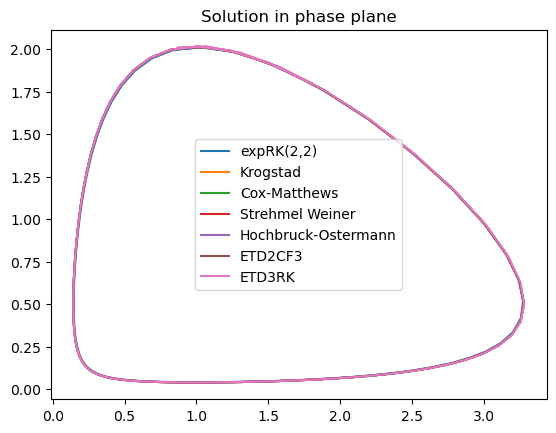

In [4]:
import numpy as np
import matplotlib.pyplot as plt

methods = [
    ("exprk22", "expRK(2,2)"),
    ("k", "Krogstad"),
    ("cm", "Cox-Matthews"),
    ("sw", "Strehmel Weiner"),
    ("ho", "Hochbruck-Ostermann"),
    ("etd2cf3", "ETD2CF3"),
    ("etd3rk", "ETD3RK")
]


for tag, name in methods:
    data = np.loadtxt(f"lv_demo/lv_exprk_{tag}.dat")
    x_e = data[:,1]
    y_e = data[:,2]
    plt.plot(x_e[:int(len(x_e)/10)], y_e[:int(len(x_e)/10)], "-", label=name)
    del data

plt.title("Solution in phase plane")
plt.legend()
plt.show()

In [5]:
def V(x,y, alpha=2./3., beta=4./3., gamma=1., delta=1.):
    return delta*x - np.log(x) + beta*y - alpha*np.log(y)

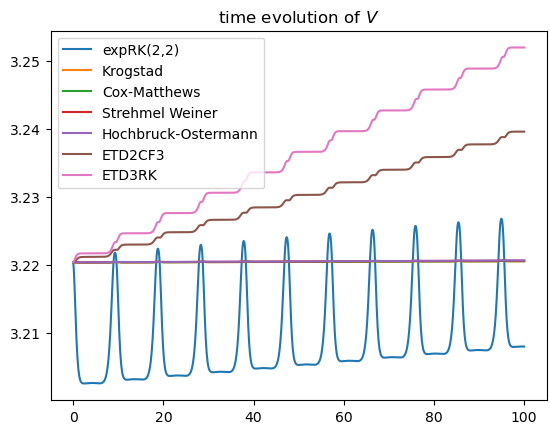

In [6]:
for i,(tag, name) in enumerate(methods):
    data = np.loadtxt(f"lv_demo/lv_exprk_{tag}.dat")
    t_e = data[:,0]
    x_e = data[:,1]
    y_e = data[:,2]
    plt.plot(t_e, V(x_e, y_e), "-", label=name)
    del data
plt.title("time evolution of $V$")
plt.legend()
plt.show()

The same graph fro only high order methods

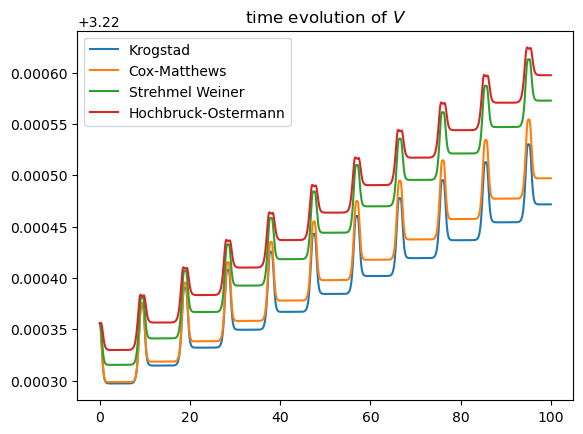

In [7]:
methods = [
    ("k", "Krogstad"),
    ("cm", "Cox-Matthews"),
    ("sw", "Strehmel Weiner"),
    ("ho", "Hochbruck-Ostermann")
]
for i,(tag, name) in enumerate(methods):
    data = np.loadtxt(f"lv_demo/lv_exprk_{tag}.dat")
    t_e = data[:,0]
    x_e = data[:,1]
    y_e = data[:,2]
    plt.plot(t_e, V(x_e, y_e), "-", label=name)
    del data
plt.title("time evolution of $V$")
plt.legend()
plt.show()